In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd

In [15]:
import datetime as dt
from sqlalchemy import create_engine,inspect,func

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [17]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [19]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [29]:
# Display the row's columns and data in dictionary format
measure=session.query(Measurement).first()
measure.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b9bdb14b38>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1}

In [30]:
# Display the row's columns and data in dictionary format
sta=session.query(Station).first()
sta.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b9bd9d6828>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [27]:
# Latest Date
latest_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
lastyear=dt.datetime.strptime(latest_date,"%Y-%m-%d")-dt.timedelta(days=365)

# Convert data format
lastyear=str(lastyear.date())

# Retrieve the last 12 months of precipitation data
last_prec=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=lastyear).all()


# Load the query results into a Pandas DataFrame and set the index to the data column
precipitation=pd.DataFrame(last_prec,columns=['Date','Precipitation'])

# Sort dataFrame values by data and remove NA values
precipitation=precipitation.sort_values('Date')
precipitation=precipitation.dropna()

precipitation.head()



,Date,Precipitation
0,2016-08-23,0.00
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
1881,2016-08-23,0.70


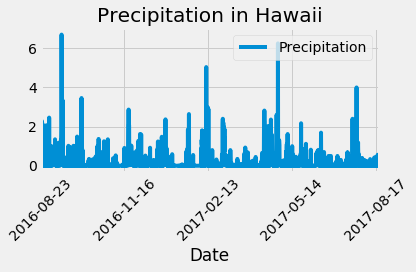

In [365]:
# Plot dates
precipitation.set_index('Date',inplace=True)
precipitation.plot(title="Precipitation in Hawaii",rot=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("Images/Precipitation.png")
plt.show()

In [223]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [31]:
# Design a query to show how many stations are available in this dataset?
avail_st=session.query(Station.station).distinct().count()
print (f"There are {avail_st} available stations")

There are 9 available stations


In [32]:

# List the stations and the counts in descending order.

# ========= Method1 =========#
# stations=pd.DataFrame(session.query(Measurement.station).all())
# stations.station.value_counts().sort_values(ascending=False)


# ======== Method2 =========#
station_count=session.query(Measurement.station,\
              func.count(Measurement.station)).\
              group_by(Measurement.station).\
              order_by(func.count(Measurement.station).desc()).all()

station_count



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_id=station_count[0][0]

station_name=session.query(Station.name).filter(Station.station==station_id).all()[0][0]

print (f"{station_id}({station_name}) is the most active station")

USC00519281(WAIHEE 837.5, HI US) is the most active station


In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temp=session.query(func.min(Measurement.tobs),\
              func.max(Measurement.tobs),\
              func.avg(Measurement.tobs)).\
              filter(Measurement.station==station_id)
             

print (f"The lowest temperature is: {temp[0][0]}\nThe highest temperature is: {temp[0][1]}\nThe highest temperature is: {round(temp[0][2],2)}")

The lowest temperature is: 54.0
The highest temperature is: 85.0
The highest temperature is: 71.66


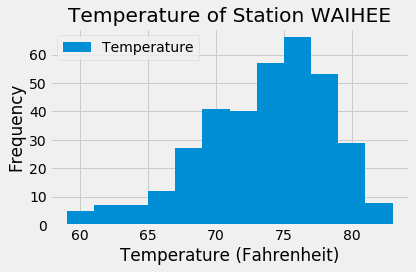

In [59]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_station=session.query(Measurement.tobs).filter(Measurement.date>=lastyear, Measurement.station==station_id).all()
temp_station=pd.DataFrame(temp_station,columns=['Temperature'])
temp_station.plot.hist(bins=12,title="Temperature of Station WAIHEE")

plt.xlabel("Temperature (Fahrenheit)")
plt.tight_layout()
plt.savefig("Images/Temperature.png")
plt.show()

In [35]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [36]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip=calc_temps('2017-08-10', '2017-08-20')
print (trip)

[(70.0, 78.42222222222222, 85.0)]


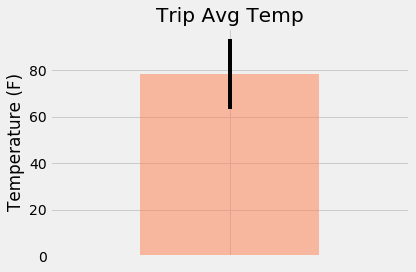

In [60]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp,avg_temp,max_temp=trip[0][0],trip[0][1],trip[0][2]


#ax.set(xticks=range(xposition), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (Fahrenheit)")
# formatting

trip_data=pd.DataFrame(trip,columns=['min_temp','avg_temp','max_temp'])
trip_data.plot.bar(y='avg_temp',yerr=trip_data.max_temp-trip_data.min_temp,color='coral',alpha=0.5, legend=False)
plt.title("Trip Avg Temp")
plt.xlabel("")
plt.ylabel("Temperature (F)")
plt.tight_layout()

# hide x-axis
plt.gca().axes.xaxis.set_ticklabels([]) 

# Save the figure and show
plt.tight_layout()
plt.savefig('Images/Trip_Temperature.png')
plt.show()


In [68]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_prec(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    sel=[Measurement.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Measurement.prcp]
    
    return session.query(*sel).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        filter(Measurement.station==Station.station).group_by(Measurement.station).\
        order_by(Measurement.prcp.desc()).all()

# function usage example
print(calc_prec('2017-08-10', '2017-08-20'))


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 0.07), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 0.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 0.0)]
